<br>
<center>
    <hr width='75%' style='height:1px'>
    <h3><b>Getting Insights into Images and their Metadata</b></h3>
    <hr width=75% style='height:1px'>
</center>
<br>

## Goal

To gain insight into an image dataset and its meta-data (e.g. label
annotations). A first aspect that can be of interest is whether this meta-data is preditable from the actual
images, i.e. if there exists patterns in the image that can be used to determine the value of the meta-data
(e.g. class membership). A second aspect of interest is to be able to identify what exact structures in
the data supports these predictions, either to verify that the obtained prediction accuracy is based on
meaningful features (and thus reproducible), or out of scientific interest, to acquire further knowledge
on the relation between pixels and metadata.

## 1. The Dataset

A Plant Disease dataset which contains images of leaves along with their metadata (plant
type, presence of disease, and type of disease) available at https://data.mendeley.com/datasets/tywbtsjrjv/1 is used. For simplicity and to reduce computation, the analysis is limited to only two classes: “apple-healthy” and “apple-black-rot” and 100 images are randomly sampled per class.

In [1]:
import numpy as np
import cv2
import os
import random
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

In [2]:
apple_healthy_folder = 'data/Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/'
apple_black_rot_folder = 'data/Plant_leave_diseases_dataset_without_augmentation/Apple___Black_rot/'

In [3]:
def load_images_from_folder(folder):
    image_list = os.listdir(folder)
    # shuffle images in the folder and return as a list
    random_image_list = random.sample(image_list,len(image_list))
    images = []
    
    # load the first 100 images in a randomly shuffled list
    for filename in random_image_list[:100]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
def display_images(images):
    # create figure
    fig = plt.figure(figsize=(20, 15))

    # setting values to rows and column variables
    rows = 10
    columns = 10
    
    for i,img in enumerate(images):
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(img)
    fig.tight_layout()
    plt.show()
    return None

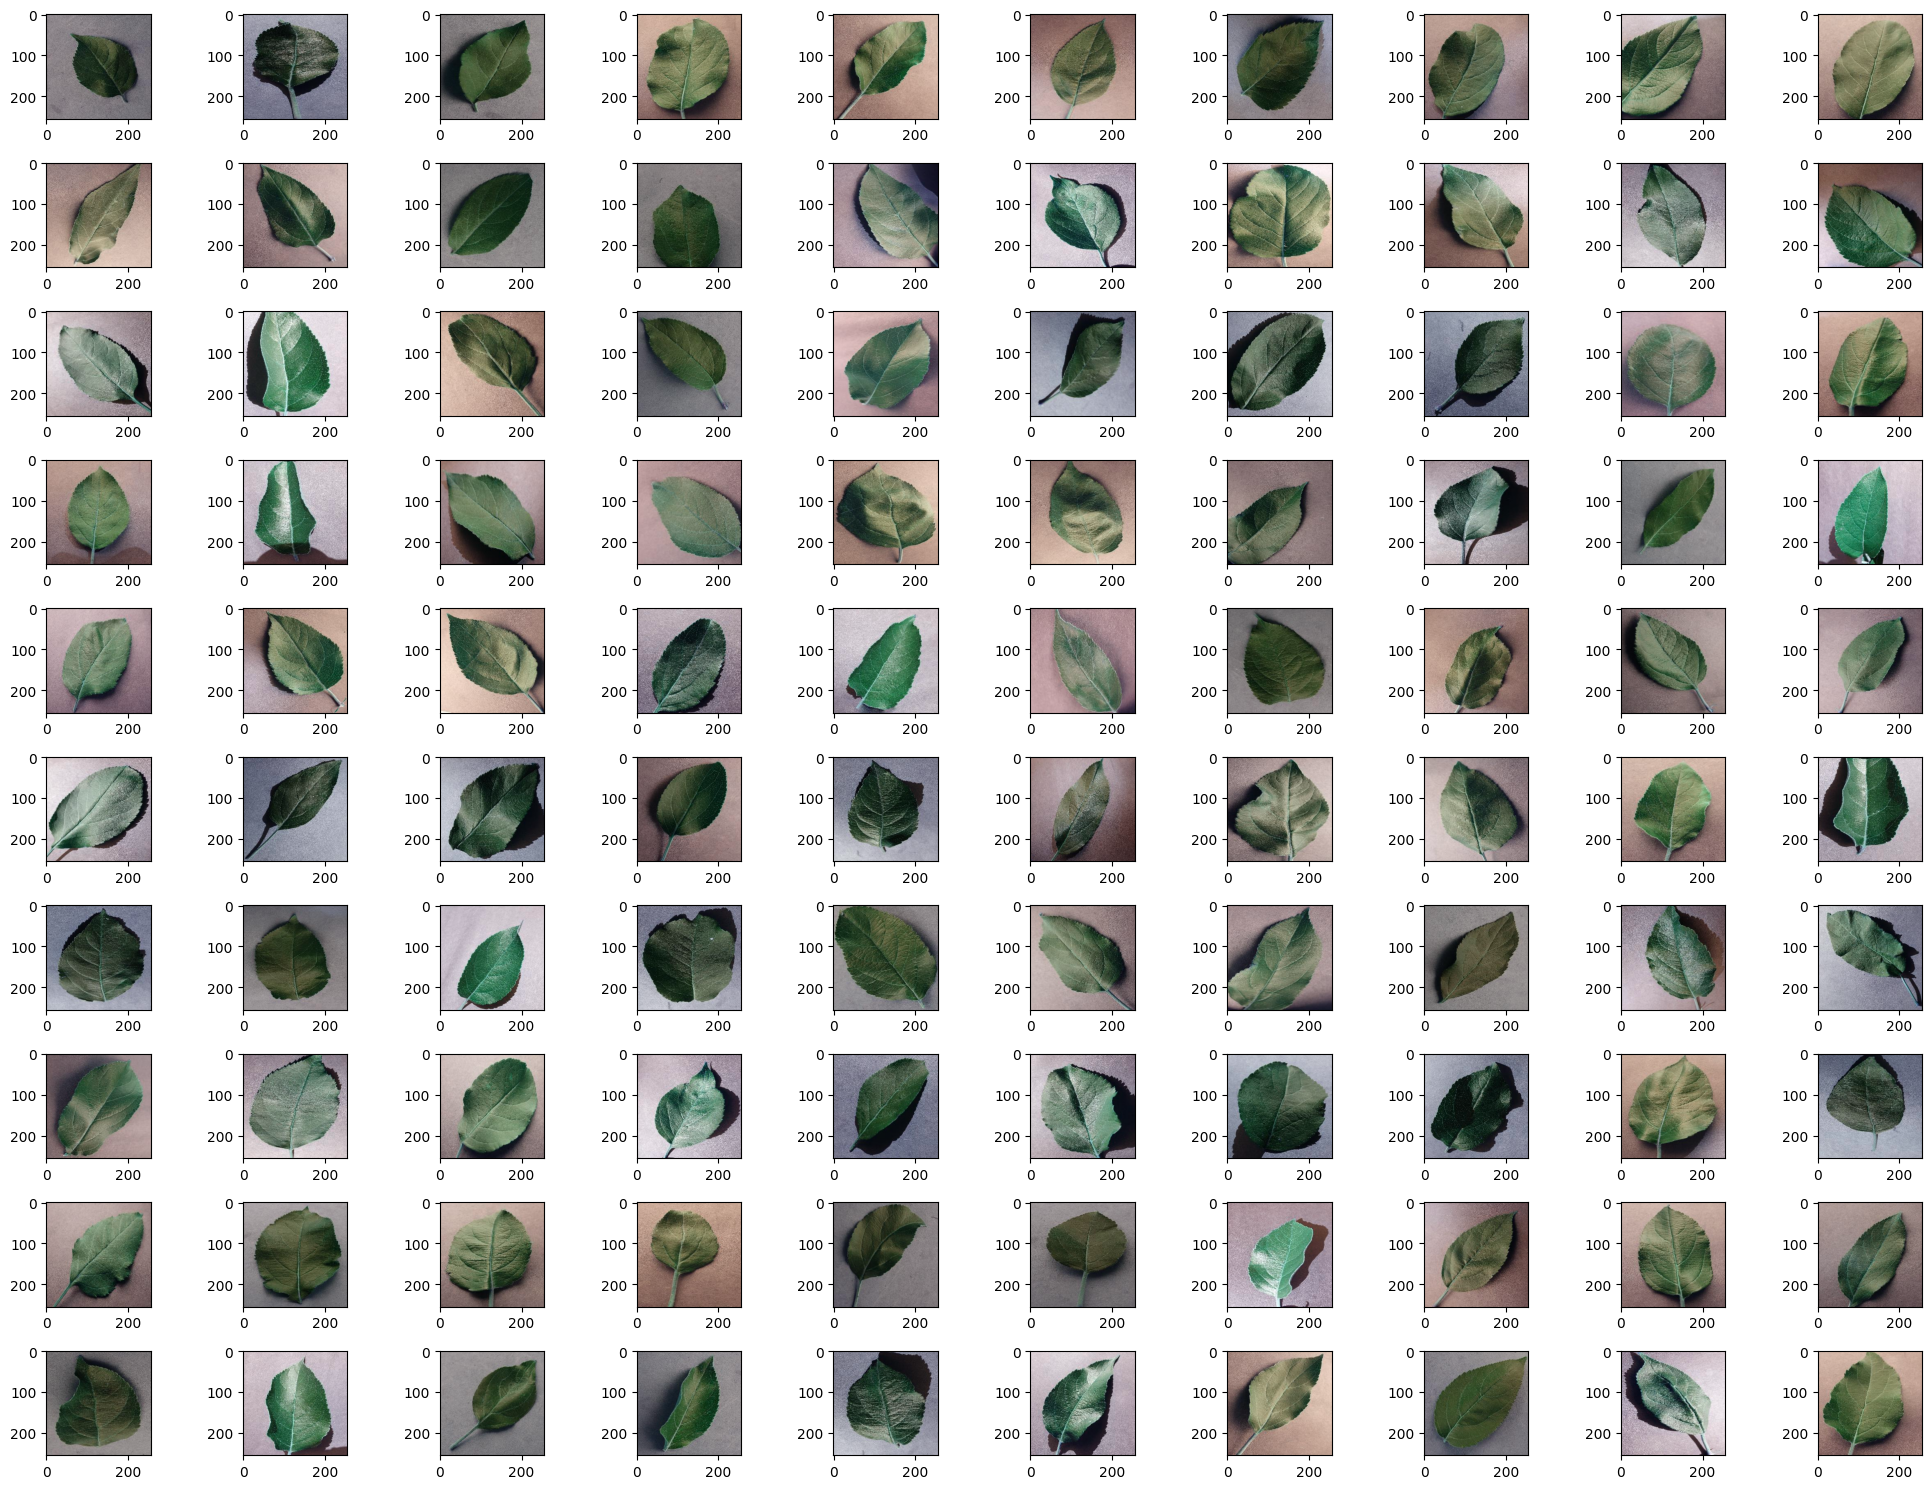

In [5]:
apple_healthy_images = load_images_from_folder(apple_healthy_folder)
display_images(apple_healthy_images)

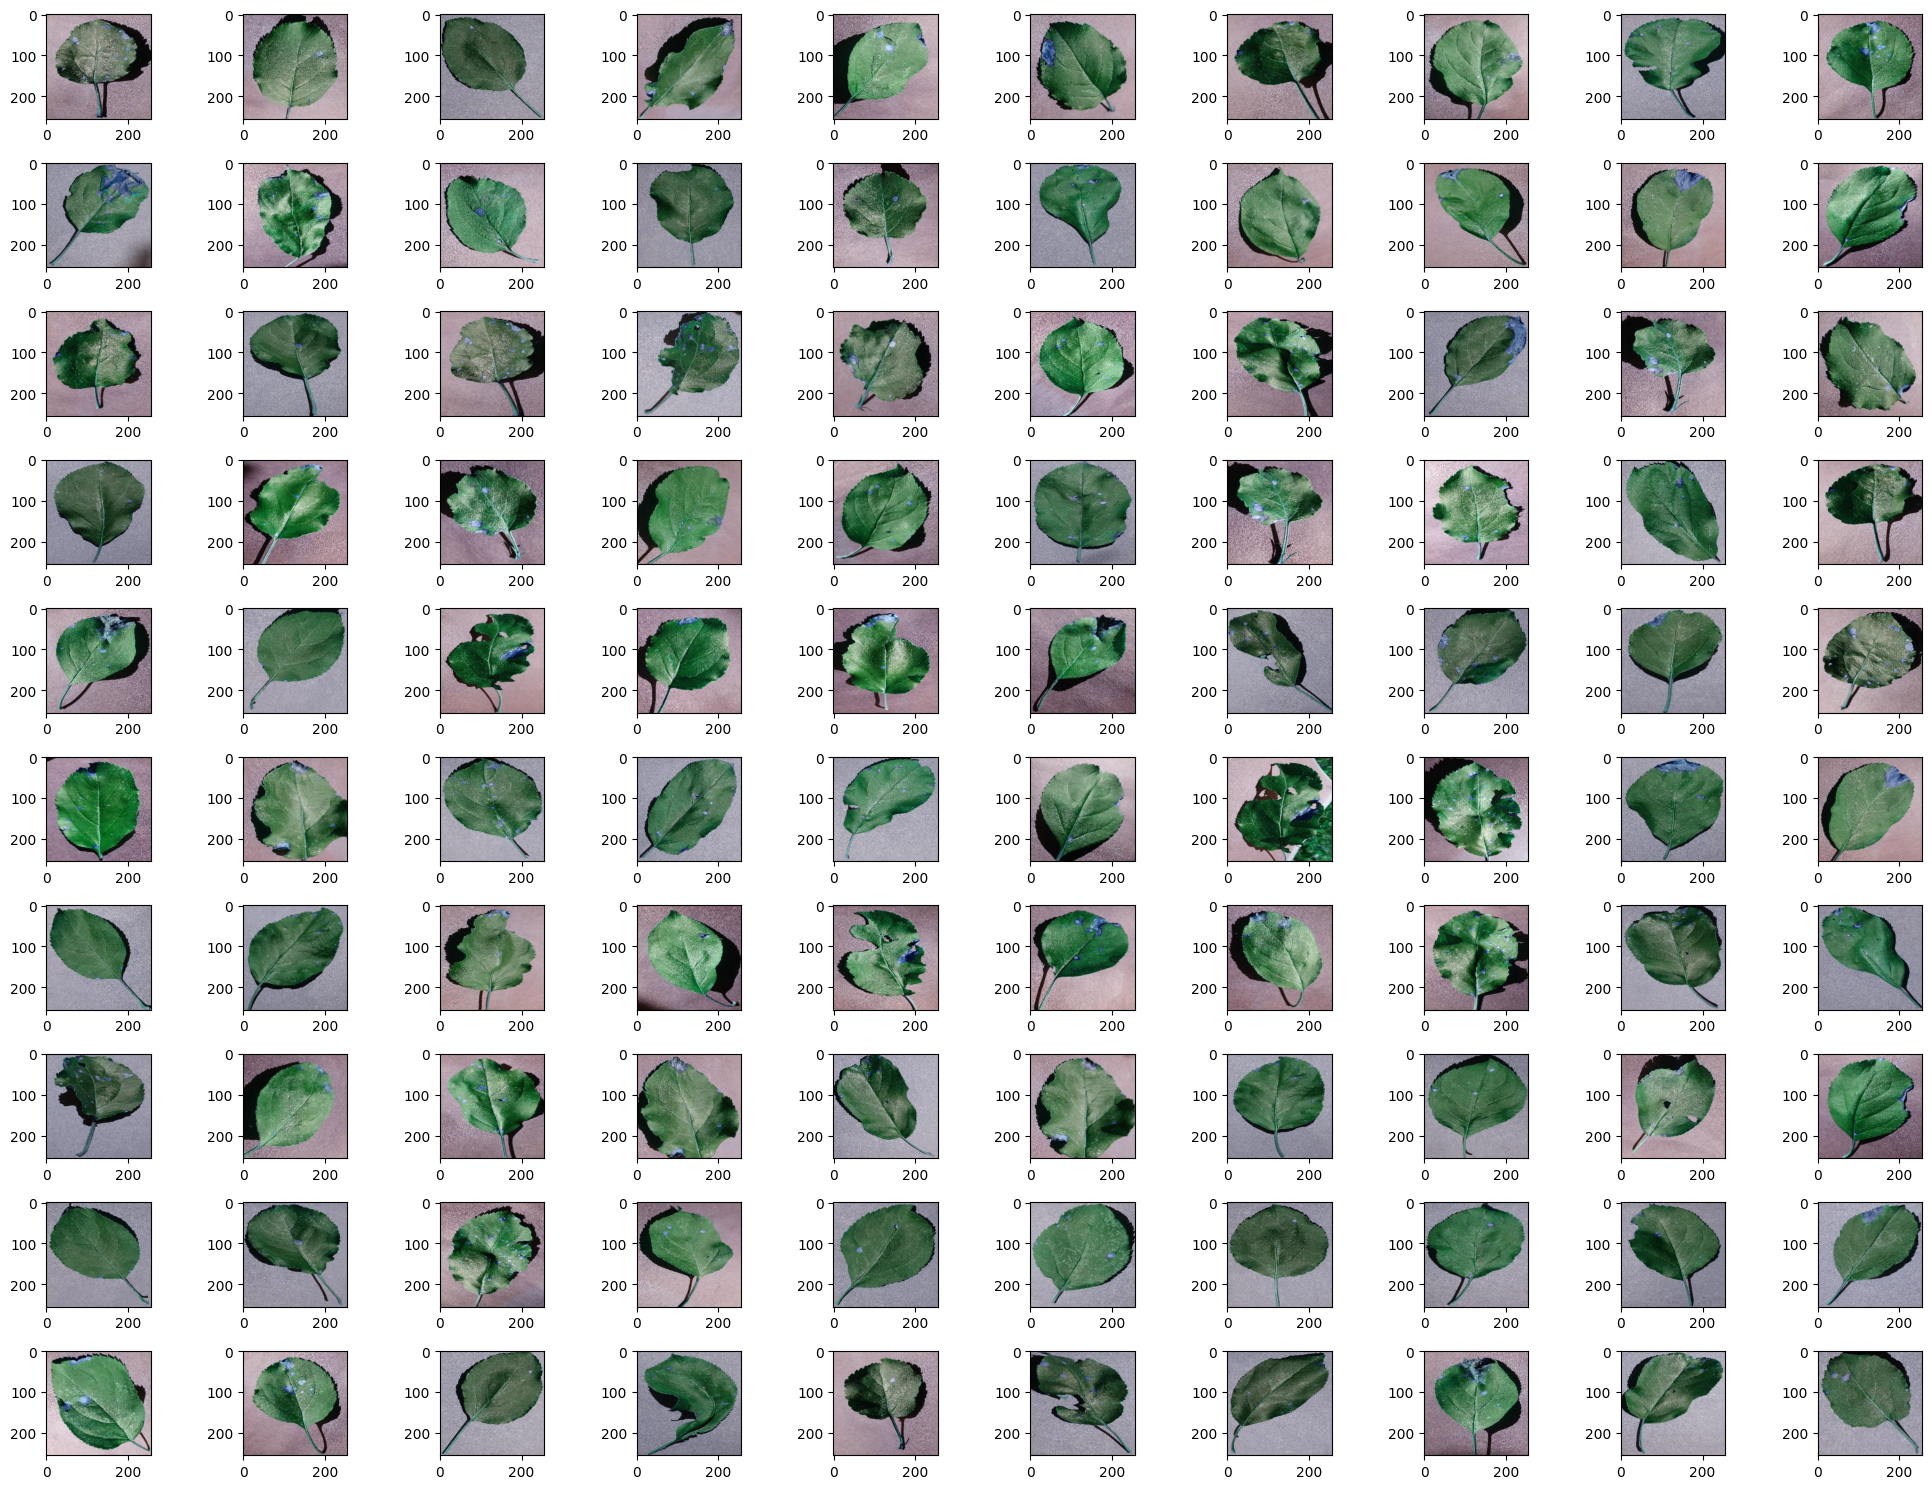

In [6]:
apple_black_rot_images = load_images_from_folder(apple_black_rot_folder)
display_images(apple_black_rot_images)

## 2. Pretrained Models for Image Recognition

The VGG-16 network is used which is available in PyTorch. It readily comes
decomposed in two parts. The first part can be found in the variable model.features, and the top part
in the variable model.classifier. The Top layers are task-specific and do not transfer to new tasks. However, lower
layers are composed of more general features. When transferring one such network to a new task, it is
therefore common to remove the top layers.

We refer to the mapping performed by the first part
of the network (i.e. model.features) as the function Φ(x), and our subsequent analysis will be performed
on the representation at the output of that function.


In [ ]:
# VGG-16 Takes 224x224 images as input, so we resize all of them
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),                     # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),                # Resize the image to 224x224
    transforms.ToTensor(),                        # Convert PIL Image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize the image tensor
                         [0.229, 0.224, 0.225])
])


def apply_transformation(images):
    """transfomation function for images"""
    
    pre_processed_images = []    # Declare empty list for preprocessed images
    
    for img in images:
        pre_processed_image = transform(img)
        pre_processed_images.append(pre_processed_image)
    
    return pre_processed_images

# Apply the transformation to each image
class_1_preprocessed_images = apply_transformation(apple_healthy_images)    # Preprocessed apple_healthy_images
class_2_preprocessed_images = apply_transformation(apple_black_rot_images)  # Preprocessed apple_black_rot_images

# Convert the list of preprocessed images to a single tensor
class_1_tensor = torch.stack(class_1_preprocessed_images)
class_2_tensor = torch.stack(class_2_preprocessed_images)

print("Apple healthy tensor shape: ", class_1_tensor.shape)
print("Apple black rot tensor shape: ", class_2_tensor.shape)

Apple healthy tensor shape:  torch.Size([100, 3, 224, 224])
Apple black rot tensor shape:  torch.Size([100, 3, 224, 224])


In [8]:
# Load the VGG-16 network without batch normalization
model = models.vgg16(weights=True)


/home/the_guard/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Remove the top layers of the VGG-16 network
# classifier = model.classifier
model = model.features
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
# Define the function Phi(x)
def phi(model, x):
    return model(x)

## 3. Predicting Classes from Images

A common model for discriminating between two classes is the difference of means. Let $D = \{x_1, . . . , x_N \}$
be the images from our dataset, and $C_1$, $C_2$ be the set of indices corresponding to images of each class. The
mean for the two classes (in feature space) can be computed as:

$$\mu_1 = \frac{1}{|C_1|} \sum_{i \in C_1} \Phi(x_i)$$

$$\mu_2 = \frac{1}{|C_2|} \sum_{i \in C_2} \Phi(x_i)$$

Based on these two mean vectors, one can identify the direction of the difference of means:

$$w = \frac{\mu_2 - \mu_1}{||\mu_2 - \mu_1||}$$

And build a simple the discriminant function which projects the data on this direction. This allows us to
score any new instance w.r.t. its predicted membership to the first or second class:

$$g(x) = w^\intercal\Phi(x)$$

The ability of our ‘difference-of-means’ discriminant to resolve the classes can
be measured using metrics such as the “area under the ROC curve” (or AUC).

In [11]:
X_tensor = torch.cat((class_1_tensor, class_2_tensor), 0)    # input data
Y_tensor = torch.cat((torch.zeros(len(class_1_tensor)), torch.ones(len(class_2_tensor))), 0)    # labels

# Split train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2)

# Apply X_train in function phi
results = phi(model, X_train)

# Compute the mean vectors for each class in feature space
mean_1 = torch.mean(results[Y_train == 0], dim=0)
mean_2 = torch.mean(results[Y_train == 1], dim=0)

# Calculate the difference of means vector
diff_of_means = mean_2 - mean_1

# Direction of the difference of means vector
w = diff_of_means / torch.norm(diff_of_means)

# Define the discriminant function
def get_score(results, w): 
    """Compute the discriminant function g(x)"""
    
    # Flatten the tensor
    flattened_results = results.view(len(results), -1)
    
    # Flatten the direction tensor w
    flattened_w = torch.flatten(w)
    g = torch.matmul(flattened_results, flattened_w)
    return g

# Get discriminant_function scores for each class
g_class_1 = get_score(phi(model, X_test[Y_test == 0]), w)
g_class_2 = get_score(phi(model, X_test[Y_test == 1]), w)

print(f'Score for the heatlhy class: {torch.mean(g_class_1):.3f}')
print(f'Score for the rot class: {torch.mean(g_class_2):.3f}')

# Get score for prediction
predictions = get_score(phi(model, X_test), w)

# Compute the ROC score
roc = roc_auc_score(Y_test, predictions.detach().numpy())

# Print the RUC score and the number of instances for each class
print(f'ROC score: {roc:.3f}')
print(f'Class \t \t #Train \t \t #Test')
print(f'healthy \t \t {len(results[Y_train == 0])} \t \t {len(predictions[Y_test == 0])}')
print(f'blackrot \t \t {len(results[Y_train == 1])} \t \t {len(predictions[Y_test == 1])}')

Score for the heatlhy class: 7.048
Score for the rot class: 42.874
ROC score: 1.000
Class 	 	 #Train 	 	 #Test
healthy 	 	 79 	 	 21
blackrot 	 	 81 	 	 19


## 4. Understanding the Image-Class Relation Pixel-Wise

In practice, it is often of limited value to assess how well classes can be predicted from the images. Instead,
one might ask what exact input features that are relevant for carrying these accurate predictions. There
are various reasons why we would like to do this:

First, identifying relevant features enables us to validate that the high prediction accuracy is genuine
and not attributable to some artefact in the image. This enables to verify that the outcome of our analysis
remains reproducible on data without artefacts.

Second, and most importantly, this may provide further insights into the image-class relations. Indeed,
identifying relevant input features or pixels enables us to understand what exactly in the image relates to
one class or another.

### 4.1 Sensitivity Analysis

For generating these pixel-wise explanations, various techniques exist. The simplest of them looks at the
derivative of the model w.r.t. the input pixels for a given image. The resulting derivatives can be converted
to importance scores by observing that each pixel receives a 3-dimensional vector as a gradient (the RGB
channels), and then computing the square norm of that vector:

$$S_i = ||\frac{\partial g}{\partial x_i}||^2$$

The collections of pixel-wise scores $(Si)_{i=1}^d$ can be rendered as a heatmap of same size as the original image, where important features are commonly highlighted in red. Interestingly, this
analysis would reduce to analyzing the difference of mean vectors when choosing the simple feature
representation $\Phi(x) = x$

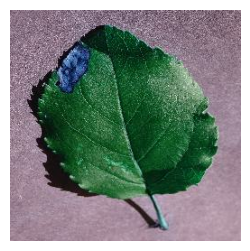

In [ ]:
image_name = 'image (127).JPG'
img = cv2.imread(os.path.join(apple_black_rot_folder,image_name))
fig = plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(img)
plt.show()

/tmp/ipykernel_24372/4160516744.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('autumn').copy()


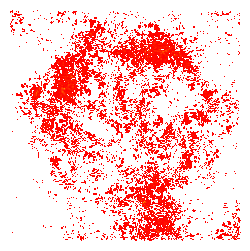

In [13]:
input_image = transform(img).unsqueeze(0)
    
# Enable gradient calculation for the input tensor
input_image.grad = None
input_image.requires_grad_(True)

# Forward pass to get the output
output = phi(model, input_image)

# get score
score = get_score(output, w)
# score.backward()

# Get the gradients of the input tensor
# gradients = input_image.grad.squeeze()
gradients = torch.autograd.grad(score, input_image)[0]
gradients = gradients.squeeze()

# Compute the pixel-wise importance scores by getting the square-norm over the RGB channels
importance_scores = gradients.norm(dim=0) ** 2

# Normalize the importance scores to [0, 1]
importance_scores = (importance_scores-importance_scores.min())/(importance_scores.max()-importance_scores.min())

# Convert importance scores to a heatmap
heatmap = importance_scores.detach().numpy()

# Create a red colormap with white background
cmap = plt.cm.get_cmap('autumn').copy()
cmap.set_under(color='white')

# Display the sensitivity scores as a heatmap
fig = plt.figure(figsize=(3, 3))
plt.imshow(heatmap, cmap=cmap, vmin=importance_scores.mean())
plt.axis('off')
plt.show()

To better the visualisation of the sensitivity analysis, the following function is used to plot the heatmap:

In [14]:
def visualize(grads):
    """ helper function to better visualize a heatmap, referenced from the ML lectures of WiSe 22/23 """
    heatmap = (torch.norm(grads, dim=0) ** 2).numpy()
    # heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    b = 7*((np.abs(heatmap)**3.0).mean()**(1.0/2.5))
    
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0] *= 0.95
    my_cmap = ListedColormap(my_cmap)
    my_cmap.set_under(color='white')

    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
    plt.imshow(heatmap,cmap=my_cmap,vmin=-b,vmax=b)
    plt.show()

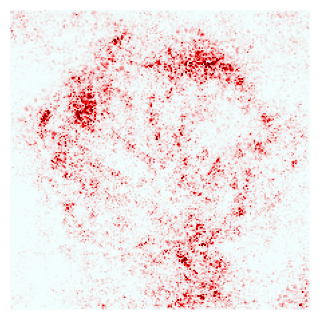

In [15]:
visualize(gradients)

### 4.2 More Robust Explanations using Smoothgrad

[SmoothGrad](https://arxiv.org/abs/1706.03825) is a simple method that can help visually sharpen gradient-based sensitivity maps. Gaussian noise is added to the image multiple times, and the resulting maps are averaged. This helps to reduce the noise in the sensitivity maps, and to highlight the most robust features. 

In [16]:
def generate_smoothgrad(model, img, num_iterations=50, magnitude=0.25):
    """
    Generates a smoothgrad by adding noise to the original image and averaging the model predictions.

    Args:
        model (torchvision.models.vgg16.features): Pre-trained model used for predictions.
        img: Original input image.
        num_iterations (int): Number of noise iterations.
        magnitude (float): Magnitude(standard deviation) of the noise added to the image.

    Returns:
        heatmap: Smoothgrad heatmap.
    """
    # Preprocess the image
    input_image = transform(img).unsqueeze(0)

    # Add Gaussian noise (mean=0, std=magnitude) and accumulate predictions
    smoothgrad = torch.zeros_like(input_image)
    for _ in range(num_iterations):
        noise = torch.randn_like(input_image) * magnitude
        perturbed_image = input_image + noise
        
        # Enable gradient calculation
        perturbed_image.requires_grad = True
        perturbed_image.grad = None

        # Forward pass
        output = phi(model, perturbed_image)

        # Get score and compute gradients
        score = get_score(output, w)
        grad = torch.autograd.grad(score, perturbed_image)[0]

        # Accumulate predictions weighted by gradients
        smoothgrad += grad

    # Average the accumulated predictions
    smoothgrad /= num_iterations

    return smoothgrad.squeeze()

In [17]:
sg = generate_smoothgrad(model, img, num_iterations=50, magnitude=0.25)

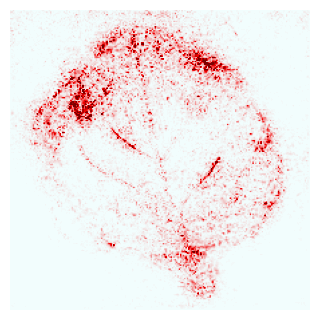

In [18]:
visualize(sg)

### 4.3 Discussion

There are multiple factors that could impact a mismatch between the highlighted relevant pixels and the region of the leaf where the disease is visible in the smoothgrad heatmap. Some possible factors are due to:
insufficiently good pre-trained neural network, improper method for extracting relevant features, problems with data quality, or flawed understanding by humans.

We can tackle the data quality problem with ensuring that the dataset contains a sufficient number of samples representing different variations. We only have 80 training images of black rot apple. If we have sufficient resources, we can overcome this issue with more training data including different rotten severities, lighting conditions, and leaf angles. This can help the model learn a robust representation of the disease.

The other option is to try using a different pre-trained model or a model specifically trained on plant disease detection if available. We can consider fine-tuning the pre-trained model on a dataset that is more specific to the plant disease. This can help the model learn disease-specific features better.

It is important to note that explainability in deep learning models is an ongoing research area, and there is no one solution.